# umap

In [ ]:
from __future__ import annotations

import matplotlib.pyplot as plt
import pandas as pd
import scanpy as sc

sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.set_figure_params(dpi=80, facecolor="white")
sc.logging.print_header()


adata = sc.read_10x_mtx(
    "data/filtered_gene_bc_matrices/hg19/",  # the directory with the `.mtx` file
    var_names="gene_symbols",  # use gene symbols for the variable names (variables-axis index)
    cache=True,  # write a cache file for faster subsequent reading
)
adata.var_names_make_unique()  # this is unnecessary if using `var_names='gene_ids'` in `sc.read_10x_mtx`

sc.pp.filter_cells(adata, min_genes=200)  # this does nothing, in this specific case
sc.pp.filter_genes(adata, min_cells=3)

# annotate the group of mitochondrial genes as "mt"
adata.var["mt"] = adata.var_names.str.startswith("MT-")
sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], percent_top=None, log1p=False, inplace=True)

sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True,
)

fig, axs = plt.subplots(1, 2, figsize=(10, 4), layout="constrained")
sc.pl.scatter(adata, x="total_counts", y="pct_counts_mt", show=False, ax=axs[0])
sc.pl.scatter(adata, x="total_counts", y="n_genes_by_counts", show=False, ax=axs[1]);

adata = adata[
    (adata.obs.n_genes_by_counts < 2500) & (adata.obs.n_genes_by_counts > 200) & (adata.obs.pct_counts_mt < 5),
    :,
].copy()
adata.layers["counts"] = adata.X.copy()

sc.pp.normalize_total(adata, target_sum=1e4)

sc.pp.log1p(adata)


sc.pp.highly_variable_genes(
    adata,
    layer="counts",
    n_top_genes=2000,
    min_mean=0.0125,
    max_mean=3,
    min_disp=0.5,
    flavor="seurat_v3",
)

sc.pl.highly_variable_genes(adata)


adata.layers["scaled"] = adata.X.toarray()
sc.pp.regress_out(adata, ["total_counts", "pct_counts_mt"], layer="scaled")
sc.pp.scale(adata, max_value=10, layer="scaled")

# PCA
sc.pp.pca(adata, layer="scaled", svd_solver="arpack")
sc.pl.pca(adata, annotate_var_explained=True, color="CST3")
sc.pl.pca_variance_ratio(adata, n_pcs=20)
sc.pl.pca_loadings(adata, components=(1, 2), include_lowest=True)

# 计算邻域图
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)

# Leiden聚类
sc.tl.leiden(
    adata,
    resolution=0.7,
    random_state=0,
    flavor="igraph",
    n_iterations=2,
    directed=False,
)

adata

# sc.tl.paga()

running PAGA
    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:00:00)
--> added 'pos', the PAGA positions (adata.uns['paga'])


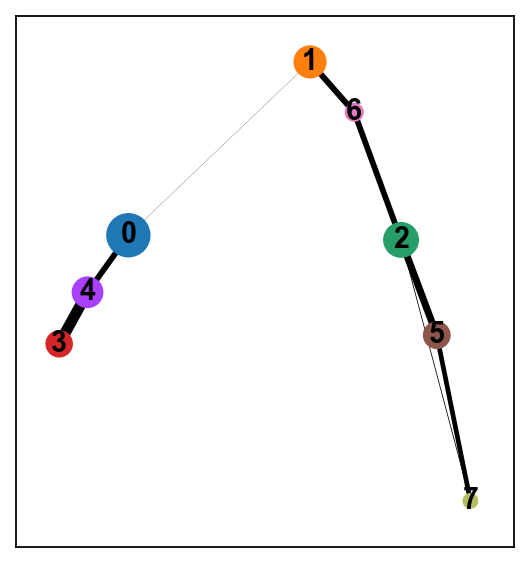

In [ ]:
sc.tl.paga(adata)
# 必须sc.pl.paga，否则umap出错
sc.pl.paga(adata, plot=True)  # remove `plot=False` if you want to see the coarse-grained graph

# sc.tl.umap

In [ ]:
sc.tl.umap(adata, init_pos='paga')
sc.tl.umap(adata)
#sc.pl.umap(adata, color=["leiden", "CD14", "NKG7"])

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:03)


In [ ]:
adata

# 源码解析

## sc.tl.paga()

需要输入：
- 邻近细胞
- Leiden聚类

In [ ]:
def paga(
    adata: AnnData,
    groups: str | None = None,
    *,
    use_rna_velocity: bool = False,
    model: Literal["v1.2", "v1.0"] = "v1.2",
    neighbors_key: str | None = None,
    copy: bool = False,
) -> AnnData | None:
    """
    基于分区的图抽象（PAGA）通过量化单细胞图分区（群组、簇）间的连接性，生成结构简化的分区抽象图（PAGA图），
    其边权表征连接存在的置信度。通过在 :func:~scanpy.pl.paga中对该置信度进行阈值筛选，可获得流形数据的简化表征，
    同时保持对原始流形拓扑结构的忠实性。

    Parameters
    ----------
    groups
        分组，可以提供事先分好的组，即 adata.obs 中的分类变量。默认是 leiden, louvain
    neighbors_key
        .obsp['connectivities']
        .obsp['distances'

    Returns
    -------
    adata.uns['paga']

    adata.uns['leiden_sizes']
    """
    # 检查邻近细胞键，要提前做邻近细胞分析 sc.tl.neighbors()
    # check_neighbors = 'neighbors'
    check_neighbors = "neighbors" if neighbors_key is None else neighbors_key
    if check_neighbors not in adata.uns:
        msg = "You need to run `pp.neighbors` first to compute a neighborhood graph."
        raise ValueError(msg)
    
    # 检查分组，要提前做Leiden聚类，结果保存在 adata.obs['leiden'] 当中
    if groups is None:
        for k in ("leiden", "louvain"):
            if k in adata.obs.columns:
                groups = k
                break
    if groups is None:
        msg = (
            "You need to run `tl.leiden` or `tl.louvain` to compute "
            "community labels, or specify `groups='an_existing_key'`"
        )
        raise ValueError(msg)
    elif groups not in adata.obs.columns:
        msg = f"`groups` key {groups!r} not found in `adata.obs`."
        raise KeyError(msg)

    adata = adata.copy() if copy else adata
    _utils.sanitize_anndata(adata)
    start = logg.info("running PAGA")

    # 做PAGA分析
    paga = PAGA(adata, groups, model=model, neighbors_key=neighbors_key)
    # only add if not present
    if "paga" not in adata.uns:
        adata.uns["paga"] = {}
    if not use_rna_velocity:
        paga.compute_connectivities()
        adata.uns["paga"]["connectivities"] = paga.connectivities
        adata.uns["paga"]["connectivities_tree"] = paga.connectivities_tree
        # adata.uns['paga']['expected_n_edges_random'] = paga.expected_n_edges_random
        adata.uns[f"{groups}_sizes"] = np.array(paga.ns)
    else:
        paga.compute_transitions()
        adata.uns["paga"]["transitions_confidence"] = paga.transitions_confidence
        # adata.uns['paga']['transitions_ttest'] = paga.transitions_ttest
    adata.uns["paga"]["groups"] = groups
    logg.info(
        "    finished",
        time=start,
        deep="added\n"
        + (
            "    'paga/transitions_confidence', connectivities adjacency (adata.uns)"
            # "    'paga/transitions_ttest', t-test on transitions (adata.uns)"
            if use_rna_velocity
            else "    'paga/connectivities', connectivities adjacency (adata.uns)\n"
            "    'paga/connectivities_tree', connectivities subtree (adata.uns)"
        ),
    )
    """
    (Pdb) adata.uns['paga']
    {'connectivities': <Compressed Sparse Row sparse matrix of dtype 'float64'
        with 30 stored elements and shape (8, 8)>, 'connectivities_tree': <Compressed Sparse Row sparse matrix of dtype 'float64'
        with 7 stored elements and shape (8, 8)>, 'groups': 'leiden'}

    (Pdb) adata.uns['leiden_sizes']
    array([1178,  343,  479,  152,  284,  159,   30,   13])
    """
    return adata if copy else None

## sc.tl.umap()

umap计算的结果是用2个值表达1个细胞，可以画在平面上。

In [ ]:
def umap(  # noqa: PLR0913, PLR0915
    adata: AnnData,
    *,
    min_dist: float = 0.5,
    spread: float = 1.0,
    n_components: int = 2,
    maxiter: int | None = None,
    alpha: float = 1.0,
    gamma: float = 1.0,
    negative_sample_rate: int = 5,
    init_pos: _InitPos | np.ndarray | None = "spectral",
    random_state: _LegacyRandom = 0,
    a: float | None = None,
    b: float | None = None,
    method: Literal["umap", "rapids"] = "umap",
    key_added: str | None = None,
    neighbors_key: str = "neighbors",
    copy: bool = False,
) -> AnnData | None:
    """
    使用UMAP对邻域图进行嵌入

    UMAP（均匀流形逼近与投影）是一种适用于高维数据可视化的流形学习技术。相较于tSNE，UMAP不仅计算速度更快，
    更能通过优化嵌入结果使其最佳反映数据的拓扑结构——在Scanpy中我们使用邻域图来表征这种拓扑结构。相比之下，
    tSNE优化的目标是使嵌入空间中的最近邻距离分布与高维空间中的距离分布达到最佳匹配。

    Parameters
    ----------

    init_pos
        低维嵌入初始化方法:
        - adata.obsm的任意键
        - paga 位置
        - spectral 采用图谱嵌入法 （默认）
        - random 随机
        - 一个numpy数组
    key_added
        如果未提供，结果保存在：
        adata.obsm['X_umap']
        adata.uns['umap']
    neighbors_key
        邻近细胞键

    Returns
    -------

    adata.obsm['X_umap' | key_added]
    adata.uns['umap' | key_added]
    """
    adata = adata.copy() if copy else adata

    # 默认键名
    key_obsm, key_uns = ("X_umap", "umap") if key_added is None else [key_added] * 2

    # 领近细胞键名
    if neighbors_key is None:  # backwards compat
        neighbors_key = "neighbors"
    if neighbors_key not in adata.uns:
        msg = f"Did not find .uns[{neighbors_key!r}]. Run `sc.pp.neighbors` first."
        raise ValueError(msg)

    start = logg.info("computing UMAP")

    # 初始化领近细胞
    neighbors = NeighborsView(adata, neighbors_key)

    # 检查邻近细胞是否是 umap 方法计算的
    if "params" not in neighbors or neighbors["params"]["method"] != "umap":
        logg.warning(
            f'.obsp["{neighbors["connectivities_key"]}"] have not been computed using umap'
        )

    with warnings.catch_warnings():
        # umap 0.5.0
        warnings.filterwarnings("ignore", message=r"Tensorflow not installed")
        import umap

    from umap.umap_ import find_ab_params, simplicial_set_embedding

    if a is None or b is None:
        a, b = find_ab_params(spread, min_dist)
    
    # 保存a, b至.uns
    adata.uns[key_uns] = dict(params=dict(a=a, b=b))

    # adata.obsm 中的初始化位置
    if isinstance(init_pos, str) and init_pos in adata.obsm:
        init_coords = adata.obsm[init_pos]
    # paga
    elif isinstance(init_pos, str) and init_pos == "paga":
        """
        sc.tl.umap(adata, init_pos='paga')
        (Pdb) init_coords.shape
        (2638, 2)
        """
        init_coords = get_init_pos_from_paga(
            adata, random_state=random_state, neighbors_key=neighbors_key
        )
    else:
        """
        sc.tl.umap(adata)
        init_coords = 'spectral'，默认随机化方法
        """
        init_coords = init_pos  # Let umap handle it
    if hasattr(init_coords, "dtype"):
        init_coords = check_array(init_coords, dtype=np.float32, accept_sparse=False)
    
    pass

    neigh_params = neighbors["params"]
    # x 是 PCA 前面多少个成分
    # (Pdb) x.shape
    # (2638, 40)
    x = _choose_representation(
        adata,
        use_rep=neigh_params.get("use_rep", None),
        n_pcs=neigh_params.get("n_pcs", None),
        silent=True,
    )

    if method == "umap":
        x_umap, _ = simplicial_set_embedding(
            data=x,
            graph=neighbors["connectivities"].tocoo(),
            n_components=n_components
        )
    elif method == "rapids":
        pass
        # 即将放弃这种GPU方法
    
    # (Pdb) x_umap.shape
    # (2638, 2)
    # umap结果是一个2列的值，方便画平面图，用2个值表示一个细胞
    adata.obsm[key_obsm] = x_umap
    logg.info(
        "    finished",
        time=start,
        deep=(
            "added\n"
            f"    {key_obsm!r}, UMAP coordinates (adata.obsm)\n"
            f"    {key_uns!r}, UMAP parameters (adata.uns)"
        ),
    )
    return adata if copy else None


In [25]:
adata.uns['umap']

{'params': {'a': np.float64(0.5830300205483709),
  'b': np.float64(1.334166992455648)}}